# 1. Connect to drive and Imports

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/Colab Notebooks/AML Final Project 2

/content/drive/MyDrive/Colab Notebooks/AML Final Project 2


In [ ]:
import torch
from torch import nn
from torch import optim
import numpy as np
import matplotlib.pyplot as plt

import torchvision.transforms as T
from torchvision.io import read_image
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms.functional import InterpolationMode
import math
import torch.nn.functional as F
import os
import cv2

from sklearn.model_selection import train_test_split
from torch.utils.data import Subset

import h5py

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# 2. TrainDataset & Load Data

## Load Data

In [ ]:
def create_mask(shape, undersampling_factor = 10**2, lambda_poisson= 0.2):
    # shape should be a square
    side = shape[1]
    mask_shape = (side, side)
    mask1 = torch.zeros(mask_shape)
    side_factor = int(math.sqrt(undersampling_factor))
    middle = side // 2
    start = int(middle - middle // side_factor)
    end = int(middle + middle // side_factor)
    mask1[start:end, start:end] = 1

    # Poisson noise
    mask2 = torch.poisson(torch.full(mask_shape, lambda_poisson))
    # Binarize
    mask2 = (mask2 > 0).float()

    # logical OR
    mask = torch.logical_or(mask1, mask2)

    return mask

In [ ]:
class TrainDataset(Dataset):
  def __init__(self, image_dir, transform=None):
    super(TrainDataset, self).__init__()

    self.image_dir = image_dir
    self.transform = transform

    # preloading the data
    h5_list = sorted(os.listdir(image_dir))

    # initialize the lists to store the data
    self.mri_images = []

    # open every h5 file and read the data
    for h5_file in h5_list:
      h5_path = os.path.join(image_dir, h5_file)
      with h5py.File(h5_path, 'r') as file:
        mri_data = file['kspace'][:]

        num_slices = mri_data.shape[0]
        num_coils = mri_data.shape[1]

        # get every slice combined with every coil as a complex number matrix
        for i in range(num_slices):
            combined_image = np.zeros_like(mri_data[0, 0])

            for j in range(num_coils):
                coil_k_space = mri_data[i, j]
                # perform inverse fourier transform and square
                coil_image = np.fft.ifft2(coil_k_space)
                coil_image = np.fft.fftshift(coil_image)
                coil_image = np.abs(coil_image)
                combined_image += coil_image**2

            # square root the combined image
            combined_image = np.sqrt(combined_image)

            # crop the image to be a square
            width = combined_image.shape[1]
            height = combined_image.shape[0]
            upper = height//2 - width//2
            lower = height//2 + width//2
            combined_image = combined_image[upper:lower, :]

            # normalize the image to be between 0 and 1
            combined_image = (combined_image - combined_image.min()) / (combined_image.max() - combined_image.min())

            # convert the image to float
            combined_image = combined_image.astype(np.float32)

            # if image is smaller than 320*320, resize it to 320*320
            if width < 320:
                combined_image = cv2.resize(combined_image, (320, 320))

            # unsqueeze the image to have 1 channel
            combined_image = np.expand_dims(combined_image, axis=0)

            # append image in list
            self.mri_images.append(torch.from_numpy(combined_image).float())

  def __len__(self):
    return len(self.mri_images)

  def __getitem__(self, idx):
    image = self.mri_images[idx]

    if self.transform:
      image = self.transform(image)

    # create the mask
    mask = create_mask(image.shape)
    # apply the mask in the k-space
    k_space = torch.fft.fftn(image)
    # center the k-space
    k_space = torch.fft.fftshift(k_space)
    # apply the mask
    k_space_m = k_space * mask
    # convert back to the image space
    masked_image = torch.fft.ifftn(k_space_m)
    # remove the imaginary part
    masked_image = torch.abs(masked_image)
    # scale the image to be between 0 and 1
    masked_image = (masked_image - masked_image.min()) / (masked_image.max() - masked_image.min())

    return image, masked_image, k_space, mask, k_space_m


In [ ]:
# dataset = TrainDataset('h5_train')
# # save the dataset
# torch.save(dataset, 'dataset_h5.pth')

In [ ]:
# load the dataset
dataset = torch.load('dataset_h5.pth')

In [ ]:
print(len(dataset))

train_samples = int(len(dataset)*0.75)
test_samples = len(dataset)-train_samples
train_set, test_set = torch.utils.data.random_split(dataset, [train_samples, test_samples])
# batch size 10
trainloader = DataLoader(train_set,batch_size=5,shuffle=True)
testloader = DataLoader(test_set,batch_size=5,shuffle=True)

160


## Look at some examples

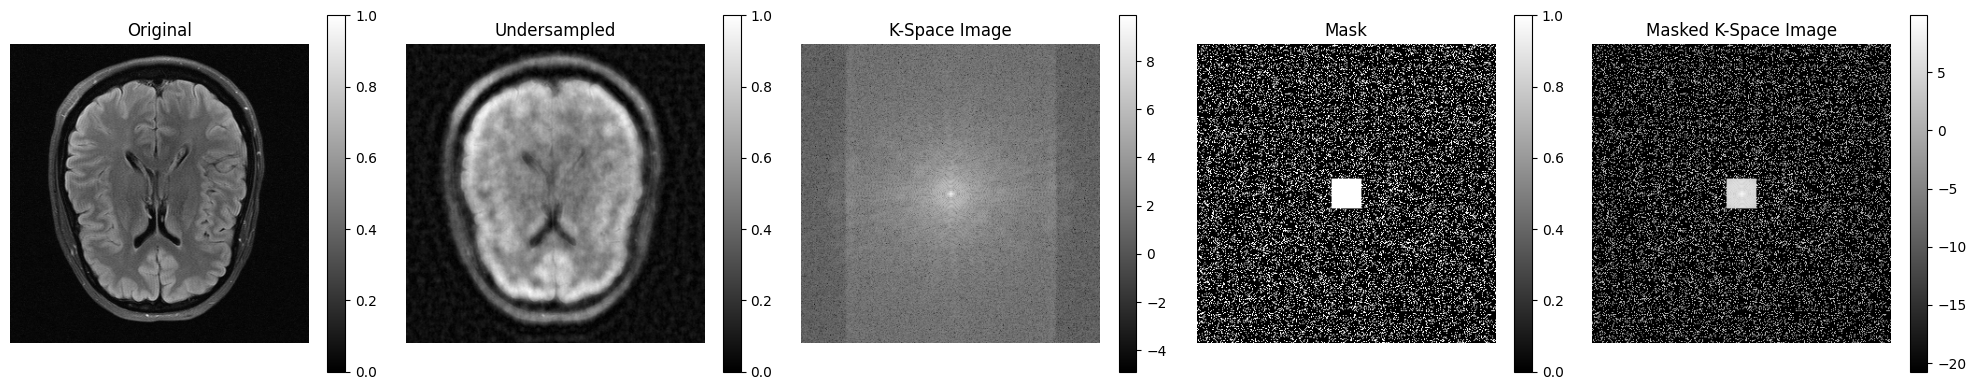

In [ ]:
# get the first image in trainloader
e_image, e_masked_image, e_k_space, e_mask, e_k_space_m = next(iter(trainloader))
# print(e_image.shape)

# squeeze the image to remove the channel dimension
e_image = e_image.squeeze(1)
e_masked_image = e_masked_image.squeeze(1)
e_k_space = e_k_space.squeeze(1)
e_mask = e_mask.squeeze(1)
e_k_space_m = e_k_space_m.squeeze(1)

# print(e_masked_image.shape)

fig, axs = plt.subplots(1, 5, figsize=(20, 4))  # 1 row, 5 columns, adjust figsize as needed

# Original Image
im0 = axs[0].imshow(np.abs(e_image[0]), cmap='gray')
axs[0].set_title('Original')
axs[0].axis('off')  # Hide the axes
fig.colorbar(im0, ax=axs[0])  # Add colorbar for each subplot

# Magnitude Image
im1 = axs[1].imshow(np.abs(e_masked_image[0]), cmap='gray')
axs[1].set_title('Undersampled')
axs[1].axis('off')
fig.colorbar(im1, ax=axs[1])

# K-Space Image
im2 = axs[2].imshow(np.log(np.abs(e_k_space[0]) + 1e-9), cmap='gray')
axs[2].set_title('K-Space Image')
axs[2].axis('off')
fig.colorbar(im2, ax=axs[2])

# Mask Image
im3 = axs[3].imshow(e_mask[0], cmap='gray')
axs[3].set_title('Mask')
axs[3].axis('off')
fig.colorbar(im3, ax=axs[3])

# Masked K-Space Image
im4 = axs[4].imshow(np.log(np.abs(e_k_space_m[0]) + 1e-9), cmap='gray')
axs[4].set_title('Masked K-Space Image')
axs[4].axis('off')
fig.colorbar(im4, ax=axs[4])

plt.tight_layout()  # Adjust the layout to make sure there's no overlap
plt.show()

# 3. Diffusion Model

## Unet

In [ ]:
class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1):
        super().__init__()
        self.down1 = DoubleConv(in_channels, 32)
        self.down2 = DoubleConv(32, 64)
        self.down3 = DoubleConv(64, 128)

        self.maxpool = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        self.up2 = DoubleConv(64 + 128, 64)
        self.up1 = DoubleConv(64 + 32, 32)

        self.final_conv = nn.Conv2d(32, out_channels, 1)

    def forward(self, x):
        x1 = self.down1(x)
        x2 = self.down2(self.maxpool(x1))
        x3 = self.down3(self.maxpool(x2))

        x = self.upsample(x3)
        x = torch.cat([x, x2], dim=1)
        x = self.up2(x)

        x = self.upsample(x)
        x = torch.cat([x, x1], dim=1)
        x = self.up1(x)

        x = self.final_conv(x)
        return x


In [ ]:
# class DoubleConv(nn.Module):
#     """(convolution => [BN] => ReLU) * 2"""
#     def __init__(self, in_channels, out_channels):
#         super().__init__()
#         self.double_conv = nn.Sequential(
#             nn.Conv2d(in_channels, out_channels, 3, padding=1),
#             nn.BatchNorm2d(out_channels),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(out_channels, out_channels, 3, padding=1),
#             nn.BatchNorm2d(out_channels),
#             nn.ReLU(inplace=True)
#         )

#     def forward(self, x):
#         return self.double_conv(x)

# class UNet(nn.Module):
#     def __init__(self, in_channels=3, out_channels=1):
#         super().__init__()
#         self.down1 = DoubleConv(in_channels, 64)
#         self.down2 = DoubleConv(64, 128)
#         self.down3 = DoubleConv(128, 256)
#         self.down4 = DoubleConv(256, 512)

#         self.maxpool = nn.MaxPool2d(2)
#         self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

#         self.up3 = DoubleConv(256 + 512, 256)
#         self.up2 = DoubleConv(128 + 256, 128)
#         self.up1 = DoubleConv(128 + 64, 64)

#         self.final_conv = nn.Conv2d(64, out_channels, 1)

#     def forward(self, x):
#         # Downsample
#         x1 = self.down1(x)
#         x2 = self.down2(self.maxpool(x1))
#         x3 = self.down3(self.maxpool(x2))
#         x4 = self.down4(self.maxpool(x3))

#         # Upsample and skip connections
#         x = self.upsample(x4)
#         x = torch.cat([x, x3], dim=1)
#         x = self.up3(x)

#         x = self.upsample(x)
#         x = torch.cat([x, x2], dim=1)
#         x = self.up2(x)

#         x = self.upsample(x)
#         x = torch.cat([x, x1], dim=1)
#         x = self.up1(x)

#         x = self.final_conv(x)
#         return x

## Diffusion Model

In [ ]:
class DPSDiffusionModel(nn.Module):
    def __init__(self):
        super().__init__()
        # Example with a simple UNet-like architecture
        self.unet = UNet(3, 1)  # Define a suitable UNet architecture

    def forward(self, x, t, y):

        # Concatenate y with x along the channel dimension before feeding it to UNet
        # print(x.device)
        # print(t.device)
        # print(y.device)

        combined_input = torch.cat([x, y, t], dim=1)

        return self.unet(combined_input)


## Training

In [ ]:
def train(model, data_loader, T=50, epochs=10):

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)

    for epoch in range(epochs):
        for x, y, _, _, _ in data_loader:
            x = x.to(device)
            y = y.to(device)

            t = torch.rand_like(x[:, :1, :, :]) * T
            noise = torch.randn_like(x)
            noisy_x = x + noise * torch.sqrt(1 - torch.exp(-2 * t / T))
            noisy_x = noisy_x.to(device)
            t = t.to(device)

            output = model(noisy_x, t, y)  # Using 'y' here

            loss = F.mse_loss(output, x)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # print(f'Batch Loss {loss.item()}')
        if epoch % 10 == 0:
            print(f'Epoch {epoch}, Loss {loss.item()}')


In [ ]:
model = DPSDiffusionModel()
# model.to(device)
train(model, trainloader, T=1000, epochs=500)

Epoch 0, Loss 0.04643743485212326
Epoch 10, Loss 0.00456096651032567
Epoch 20, Loss 0.0033650705590844154
Epoch 30, Loss 0.00256932876072824
Epoch 40, Loss 0.002963090781122446
Epoch 50, Loss 0.002655395306646824
Epoch 60, Loss 0.003927870187908411
Epoch 70, Loss 0.0031156830955296755
Epoch 80, Loss 0.002751936437562108
Epoch 90, Loss 0.00505939032882452
Epoch 100, Loss 0.00171282805968076
Epoch 110, Loss 0.0022494567092508078
Epoch 120, Loss 0.0024005447048693895
Epoch 130, Loss 0.002430290449410677
Epoch 140, Loss 0.0015240450156852603
Epoch 150, Loss 0.0026171423960477114
Epoch 160, Loss 0.0017697876319289207
Epoch 170, Loss 0.0017891640309244394
Epoch 180, Loss 0.0013597187353298068
Epoch 190, Loss 0.0012639702763408422
Epoch 200, Loss 0.002481598872691393
Epoch 210, Loss 0.001860981690697372
Epoch 220, Loss 0.004078658297657967
Epoch 230, Loss 0.0017276824219152331
Epoch 240, Loss 0.0023251166567206383
Epoch 250, Loss 0.0016049209516495466
Epoch 260, Loss 0.0010680023115128279
Epo

In [ ]:
# save the model
torch.save(model, 'v2.pth')
torch.save(model.state_dict(), 'v2_state_dict.pth')

## Load Model

In [ ]:
# Load entire model
model = torch.load('v2.pth')

# Load state dictionary (assuming the model architecture is already defined)
model.load_state_dict(torch.load('v2_state_dict.pth'))

if not callable(model):
    raise TypeError("The 'model' variable is not a callable object.")


## PSNR

In [ ]:
# calculate the PSNR
def psnr(og, pre):
    og = og.cpu()
    pre = pre.cpu()
    psnr = 10*torch.log10(og.max()/torch.mean((pre-og)**2))
    return psnr

## Train Result

In [ ]:
test_images, test_masked_images,_,_,_= next(iter(trainloader))
print(test_images.shape)

torch.Size([5, 1, 320, 320])


In [ ]:
t = torch.rand_like(test_images[:, :1, :, :]) * 1000
noise = torch.randn_like(test_images)
noisy_x = test_images + noise * torch.sqrt(1 - torch.exp(-2 * t / 1000))

noise = noise.to(device)
noisy_x = noisy_x.to(device)
t = t.to(device)
print(t.shape)
y = test_masked_images.to(device)

output = model(y, t, y)  # Using 'y' here
output = output.to(device)

test_images = test_images.to(device)

loss = F.mse_loss(output, test_images)
print(loss)

torch.Size([5, 1, 320, 320])
tensor(0.0232, device='cuda:0', grad_fn=<MseLossBackward0>)


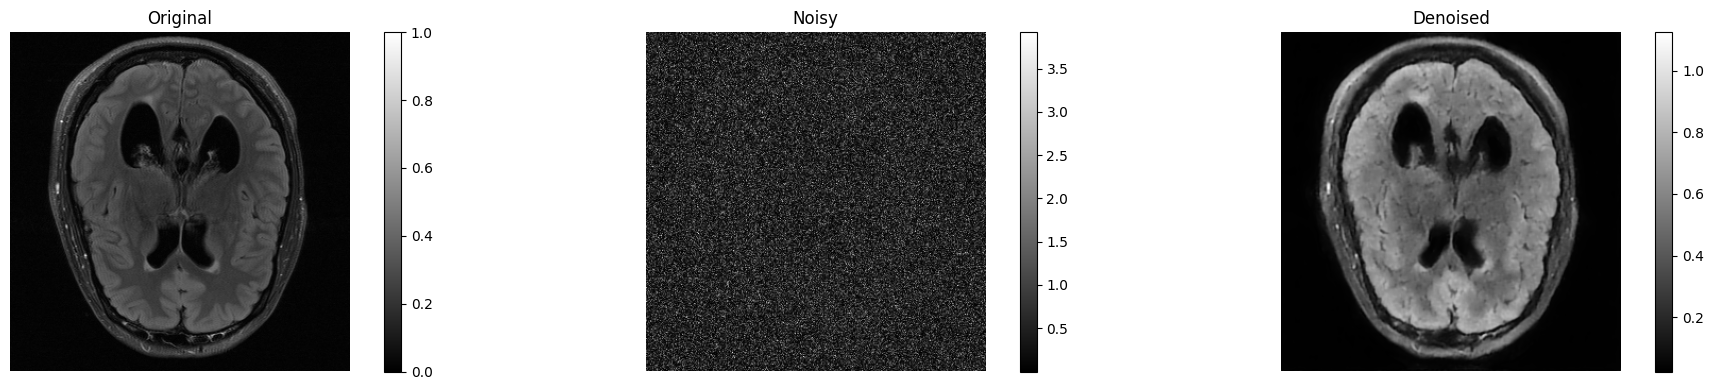

PSNR with noisy_x: tensor(2.4678)
PSNR with output: tensor(14.7793, grad_fn=<MulBackward0>)


In [ ]:
# Squueze the images to remove the channel dimension
test_images = test_images.squeeze(1)
noisy_x = noisy_x.squeeze(1)
output = output.squeeze(1)

# plot the results
fig, axs = plt.subplots(1, 3, figsize=(20, 4))  # 1 row, 3 columns, adjust figsize as needed

# Original Image
im0 = axs[0].imshow(np.abs(test_images[0].cpu().detach().numpy()), cmap='gray')
axs[0].set_title('Original')
axs[0].axis('off')  # Hide the axes
fig.colorbar(im0, ax=axs[0])  # Add colorbar for each subplot

# Noisy Image
im1 = axs[1].imshow(np.abs(noisy_x[0].cpu().detach().numpy()), cmap='gray')
axs[1].set_title('Noisy')
axs[1].axis('off')
fig.colorbar(im1, ax=axs[1])

# Denoised Image
im2 = axs[2].imshow(np.abs(output[0].cpu().detach().numpy()), cmap='gray')
axs[2].set_title('Denoised')
axs[2].axis('off')
fig.colorbar(im2, ax=axs[2])

plt.tight_layout()  # Adjust the layout to make sure there's no overlap
plt.show()

# calculate the psnr
psnr_noisy = psnr(test_images[0],noisy_x[0])
psnr_model = psnr(test_images[0],output[0])

print('PSNR with noisy_x:',psnr_noisy)
print('PSNR with output:',psnr_model)

# 4. Validation & Testing

In [ ]:
test_images, test_masked_images,_,_,_= next(iter(testloader))
print(test_images.shape)

torch.Size([5, 1, 320, 320])


In [ ]:
t = torch.rand_like(test_images[:, :1, :, :]) * 1000
noise = torch.randn_like(test_images)
noisy_x = test_images + noise * torch.sqrt(1 - torch.exp(-2 * t / 1000))

noise = noise.to(device)
noisy_x = noisy_x.to(device)
t = t.to(device)
print(t.shape)
y = test_masked_images.to(device)

mask_output = model(y, t, y)  # Using 'y' here
mask_output = mask_output.to(device)

noise_output = model(noisy_x, t, y)
noise_output = noise_output.to(device)

test_images = test_images.to(device)

mask_loss = F.mse_loss(mask_output, test_images)
noise_loss = F.mse_loss(noise_output, test_images)

# print losses
print(f'Mask Loss: {mask_loss}')
print(f'Noise Loss: {noise_loss}')

torch.Size([5, 1, 320, 320])
Mask Loss: 0.01649314910173416
Noise Loss: 0.001167553709819913


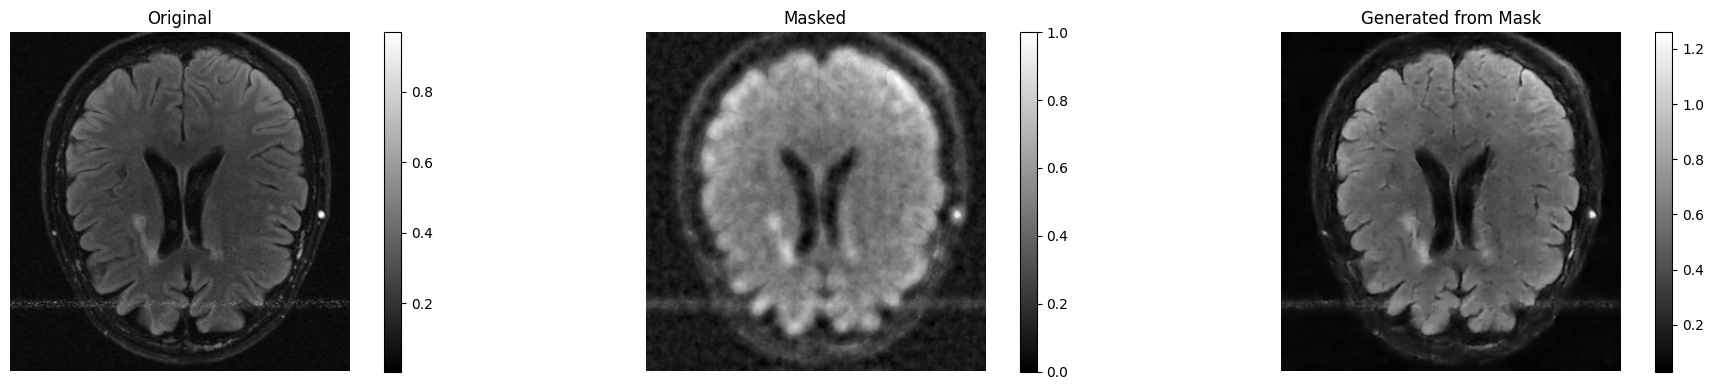

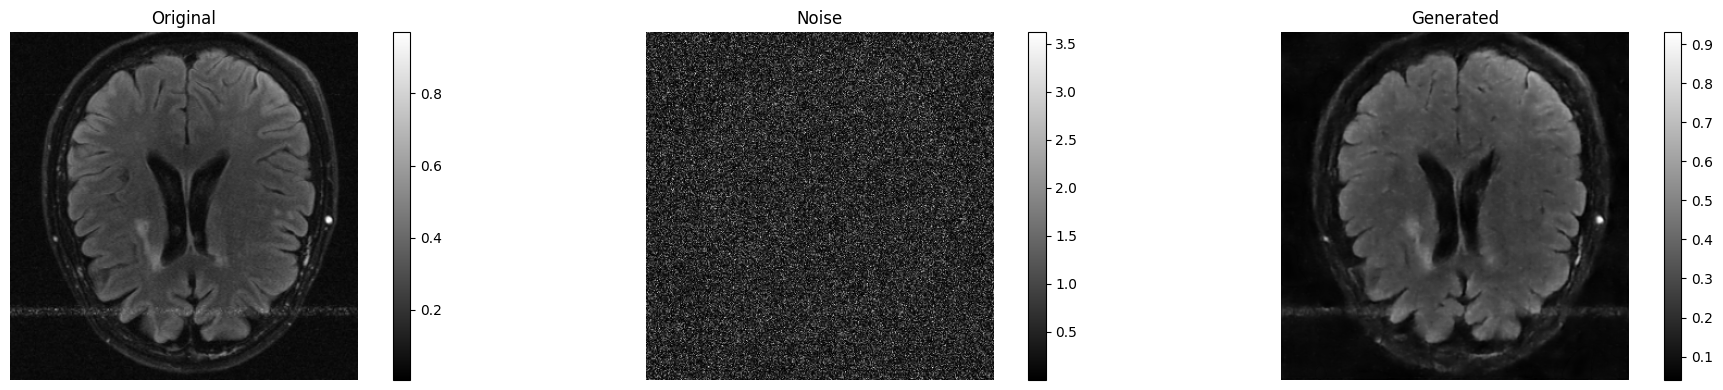

PSNR with masked: tensor(14.5485)
PSNR with masked output: tensor(15.0316, grad_fn=<MulBackward0>)

PSNR with noise: tensor(2.3014)
PSNR with noise output: tensor(28.2567, grad_fn=<MulBackward0>)


In [ ]:
# Squueze the images to remove the channel dimension
test_images = test_images.squeeze(1)
noisy_x = noisy_x.squeeze(1)
noise_output = noise_output.squeeze(1)
mask_output = mask_output.squeeze(1)
test_masked_images = test_masked_images.squeeze(1)

# plot the results
fig, axs = plt.subplots(1, 3, figsize=(20, 4))  # 1 row, 3 columns, adjust figsize as needed

# Original Image
im0 = axs[0].imshow(np.abs(test_images[0].cpu().detach().numpy()), cmap='gray')
axs[0].set_title('Original')
axs[0].axis('off')  # Hide the axes
fig.colorbar(im0, ax=axs[0])  # Add colorbar for each subplot

# Noisy Image
im1 = axs[1].imshow(np.abs(test_masked_images[0].cpu().detach().numpy()), cmap='gray')
axs[1].set_title('Masked')
axs[1].axis('off')
fig.colorbar(im1, ax=axs[1])

# Denoised Image
im2 = axs[2].imshow(np.abs(mask_output[0].cpu().detach().numpy()), cmap='gray')
axs[2].set_title('Generated from Mask')
axs[2].axis('off')
fig.colorbar(im2, ax=axs[2])

plt.tight_layout()  # Adjust the layout to make sure there's no overlap
plt.show()

# plot the results from pure noise---------------------------------------------------------------------------
fig, axs = plt.subplots(1, 3, figsize=(20, 4))  # 1 row, 3 columns, adjust figsize as needed

# Original Image
im0 = axs[0].imshow(np.abs(test_images[0].cpu().detach().numpy()), cmap='gray')
axs[0].set_title('Original')
axs[0].axis('off')  # Hide the axes
fig.colorbar(im0, ax=axs[0])  # Add colorbar for each subplot

# Noisy Image
im1 = axs[1].imshow(np.abs(noisy_x[0].cpu().detach().numpy()), cmap='gray')
axs[1].set_title('Noise')
axs[1].axis('off')
fig.colorbar(im1, ax=axs[1])

# Denoised Image
im2 = axs[2].imshow(np.abs(noise_output[0].cpu().detach().numpy()), cmap='gray')
axs[2].set_title('Generated')
axs[2].axis('off')
fig.colorbar(im2, ax=axs[2])

plt.tight_layout()  # Adjust the layout to make sure there's no overlap
plt.show()

# calculate the psnr
psnr_maksed = psnr(test_images[0],test_masked_images[0])
psnr_maksed_output = psnr(test_images[0],mask_output[0])

psnr_noisy = psnr(test_images[0],noisy_x[0])
psnr_noisy_output = psnr(test_images[0],noise_output[0])

print('PSNR with masked:',psnr_maksed)
print('PSNR with masked output:',psnr_maksed_output)
print()
print('PSNR with noise:',psnr_noisy)
print('PSNR with noise output:',psnr_noisy_output)